In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import naive_bayes, linear_model, svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from utilities import percent_survivor, one_hot_encoder
%matplotlib inline

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## __Data Cleanup and EDA:__

In [3]:
df.loc[:,'Title'] = df.Name.apply(lambda x: re.match(pattern='.+, (.+?)\..+', string=x)[1])

In [4]:
df.Title.value_counts().head(5)

Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: Title, dtype: int64

In [5]:
title_dict = {'Miss': ['Miss', 'Ms', 'Mlle'],
              'Mrs': ['Mrs', 'Mme'],
              'Mr': ['Mr'],
              'Master': ['Master'],
              'Royalty':['Lady', 'the Countess', 'Jonkheer', 'Dona', 'Rev', 'Sir'],
              'Other(s)': ['Capt', 'Col', 'Major', 'Don', 'Dr']}

In [6]:
for key, values in title_dict.items():
    df.Title.replace(values, key, inplace=True)

In [7]:
df.Title.value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Other(s)     13
Royalty      10
Name: Title, dtype: int64

In [8]:
def preprocessing(df):
    df.loc[:,'Title'] = df.Name.apply(lambda x: re.match(pattern='.+, (.+?)\..+', string=x)[1])
    title_dict = {'Miss': ['Miss', 'Ms', 'Mlle'],
              'Mrs': ['Mrs', 'Mme'],
              'Mr': ['Mr'],
              'Master': ['Master'],
              'Royalty':['Lady', 'the Countess', 'Jonkheer', 'Dona', 'Rev', 'Sir'],
              'Other(s)': ['Capt', 'Col', 'Major', 'Don', 'Dr']}
    for key, values in title_dict.items():
        df.Title.replace(values, key, inplace=True)
    
    

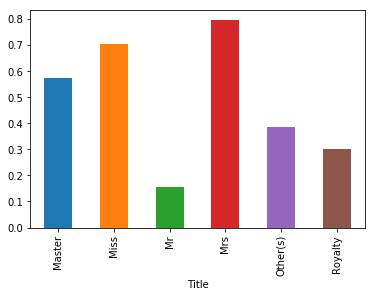

In [9]:
percent_survivor(df, 'Title').plot(kind='bar')

It's clear that older males (Mr) have a very low rate of survival.
In "royalty" and "others", there could be several women who are not accounted for. 
So this is feature is unlikely to be a major factor for determining survival.

__Calculating missing ages based on title:__

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
df.Age.isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [12]:
title_mean_age = {}
for i in df.Title.unique(): title_mean_age[i] = df[df['Title']==i].Age.mean()
for i in df[df.Age.isnull()].index: df.loc[i,'Age'] = title_mean_age[df.loc[i,'Title']]

In [13]:
df.loc[:,'Age_Range'] = pd.cut(df.Age, bins=np.append([0,12,25,35,45], float('inf')))

In [14]:
df.Age_Range.value_counts()

(25.0, 35.0]    315
(12.0, 25.0]    268
(35.0, 45.0]    131
(45.0, inf]     104
(0.0, 12.0]      73
Name: Age_Range, dtype: int64

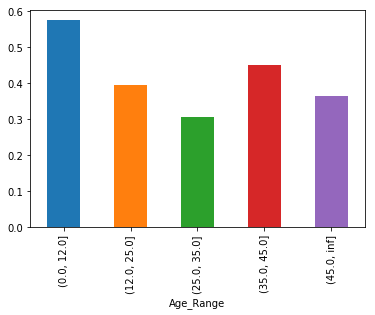

In [15]:
percent_survivor(df, 'Age_Range').plot(kind='bar')

The above chart shows children having a higher rate of survival then people of other age ranges.

In [16]:
df.loc[:,'family_size'] = df.SibSp + df.Parch

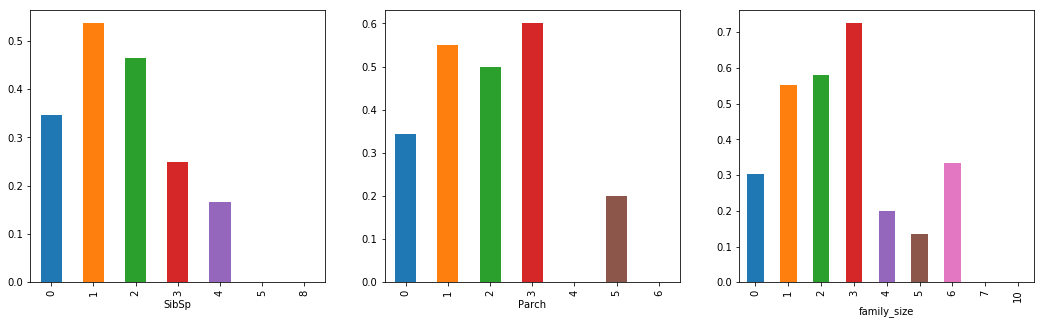

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
percent_survivor(df, 'SibSp').plot(kind='bar', ax=axes[0])
percent_survivor(df, 'Parch').plot(kind='bar', ax=axes[1])
percent_survivor(df, 'family_size').plot(kind='bar', ax=axes[2])

Overall family size of 3 implies the highest rates of survival.

In [18]:
df.Ticket.nunique()

681

Too many unique ID's to make any sense of this.

In [19]:
df.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

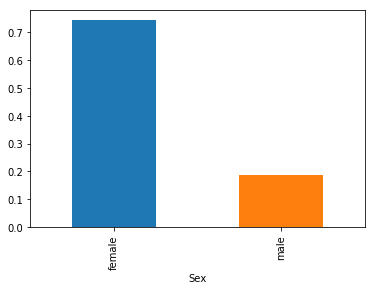

In [20]:
percent_survivor(df,'Sex').plot(kind='bar')

In [21]:
df.Pclass.value_counts(dropna=False)

3    491
1    216
2    184
Name: Pclass, dtype: int64

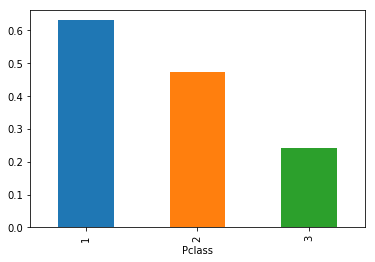

In [22]:
percent_survivor(df, 'Pclass').plot(kind='bar')

First class passengers had a higher rate of survival.

In [23]:
df.Cabin.value_counts(dropna=False).head()

NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
E101             3
Name: Cabin, dtype: int64

Too many null values to make any sense out of it.

In [24]:
df.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

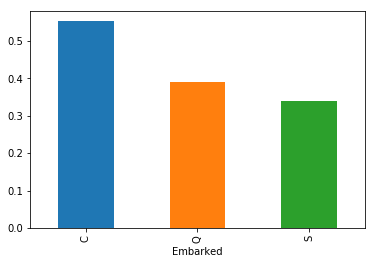

In [25]:
df.loc[df.Embarked.isnull(),'Embarked'] = 'S'
percent_survivor(df, 'Embarked').plot(kind='bar')

People embarking at C had a higher rate of survival.

In [26]:
df.loc[:,'fare_range'] = pd.cut(df.Fare, bins=np.append([0,10,25,50,100,200], float('inf')))

In [27]:
df.fare_range.value_counts()

(0.0, 10.0]       321
(10.0, 25.0]      221
(25.0, 50.0]      174
(50.0, 100.0]     107
(100.0, 200.0]     33
(200.0, inf]       20
Name: fare_range, dtype: int64

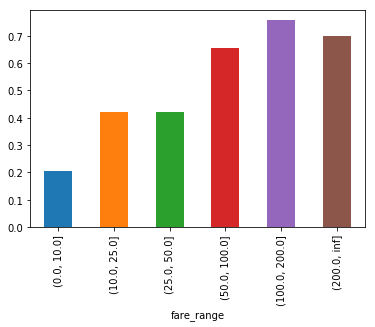

In [28]:
percent_survivor(df, 'fare_range').plot(kind='bar')

People who paid lower fares have a much lower chance of survival.

In [29]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Age_Range,family_size,fare_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(12.0, 25.0]",1,"(0.0, 10.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(35.0, 45.0]",1,"(50.0, 100.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(25.0, 35.0]",0,"(0.0, 10.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,"(25.0, 35.0]",1,"(50.0, 100.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,"(25.0, 35.0]",0,"(0.0, 10.0]"


In [30]:
x = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title','family_size','Survived']]
y = df.Survived.values

In [31]:
x.Pclass.replace({1:'first',2:'second',3:'third'}, inplace=True)
x.Sex.replace({'male': 0, 'female': 1}, inplace=True)

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [32]:
def one_hot_encoder(df, label):
    df_ = df.copy()
    for i in df_[label].unique():
        df_.loc[:, label+'_'+i] = 0
        df_.loc[df_[label]==i, label+'_'+i]=1
    return df_.drop([label], axis=1)

In [33]:
for i in ['Pclass', 'Embarked','Title']:
    x = one_hot_encoder(x, i)

In [34]:
x.head()

,Sex,Age,SibSp,Parch,Fare,family_size,Survived,Pclass_third,Pclass_first,Pclass_second,Embarked_S,Embarked_C,Embarked_Q,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Title_Other(s),Title_Royalty
0,0,22.0,1,0,7.2500,1,0,1,0,0,1,0,0,1,0,0,0,0,0
1,1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0,1,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,1,0,1,0,1,0,0,0,1,0,0,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1,0,0,0,0,0


In [36]:
n = np.arange(2, x.shape[1])
evr = []
for i in n:
    pca = PCA(n_components=i)
    pca.fit(x)
    evr.append(pca.explained_variance_ratio_.sum())

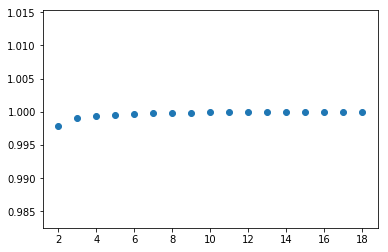

In [37]:
plt.scatter(n,evr)

In [38]:
pca = PCA(n_components=3)
X = pca.fit_transform(x)

In [39]:
def predictor(x, y, clf):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=10)
    clf.fit(x_train, y_train)
    print('Test accuracy: %0.2f%%'%(100*accuracy_score(y_test, clf.predict(x_test))))
    print('Train accuracy: %0.2f%%'%(100*accuracy_score(y_train, clf.predict(x_train))))
    return clf

In [40]:
clf = predictor(X, y, RandomForestClassifier(n_estimators=500, min_samples_split=10))

Test accuracy: 71.11%
Train accuracy: 92.38%


In [41]:
clf = predictor(X, y, DecisionTreeClassifier(min_samples_split=10))

Test accuracy: 67.78%
Train accuracy: 91.14%


In [ ]:
clf.predict()

In [ ]:
#====================== AdaBoost (74.16% accuracy)=============================
tree_clf = DecisionTreeClassifier(min_samples_split = 2, max_depth=4)
abc = AdaBoostClassifier(base_estimator = tree_clf, n_estimators=80, learning_rate=0.7)
parameters = {'n_estimators': [90], 'learning_rate': [0.9]}
clf = GridSearchCV(abc, param_grid = parameters)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output,answers['Survived'].values)

In [ ]:
#================== Logistic Regression (78.7% accuracy) =====================
clf = linear_model.LogisticRegression(C=100,solver='newton-cg',multi_class='multinomial')
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#=========================== SVM (77.75% accuracy) ============================
params = {'C':[0.001,0.01,0.1,1,10,100], 'gamma':[0.001,0.01,0.1,1,10,100]}
clf = model_selection.GridSearchCV(svm.SVC(), param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#============================== Tree =========================================
params = {"max_depth": np.arange(1, 6), "max_features": np.arange(1, 7),
         "min_samples_leaf": np.arange(1, 6), "criterion": ["gini","entropy"]}
clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)

In [ ]:
#======================== RandomForestClassifier =============================
params = {'n_estimators':[100,120], 'max_features':[5,6,7]}
clf = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),param_grid = params)
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)
#=============================================================================

In [ ]:
#============================ Naive Bayes ====================================
clf = naive_bayes.GaussianNB()
clf.fit(reduced_features, labels_train)
output = clf.predict(reduced_test)
accuracy_score = metrics.accuracy_score(output, answers['Survived'].values)
#=============================================================================

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()